In [1]:
import numpy as np
import tensorflow as tf
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras import models
from keras import layers
from ActivationHeatmap.net import cnn_net
import matplotlib.pyplot as plt
import util.image_import as ii
import json, os
from keras import backend as K
import cv2

Using TensorFlow backend.


In [10]:
crop = True

# Load model
model = cnn_net()
# Uncropped: cnn_weights
# Cropped: cnn_crop_weights
if crop:
    model.load_weights('ActivationHeatmap/cnn_crop_weights.hdf5')
else:
    model.load_weights('ActivationHeatmap/cnn_weights.hdf5')

In [11]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x*=0.1
    x+=0.5
    x = np.clip(x, 0, 1)
    x*=255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [12]:
def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    grads = K.gradients(loss, model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([model.input], [loss, grads])
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    step = 1.
    for i in range(150):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    img = input_img_data[0]
    return deprocess_image(img)

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
activation_5 (Activation)    (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
activation_6 (Activation)    (None, 109, 109, 64)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 186624)            0         
__________

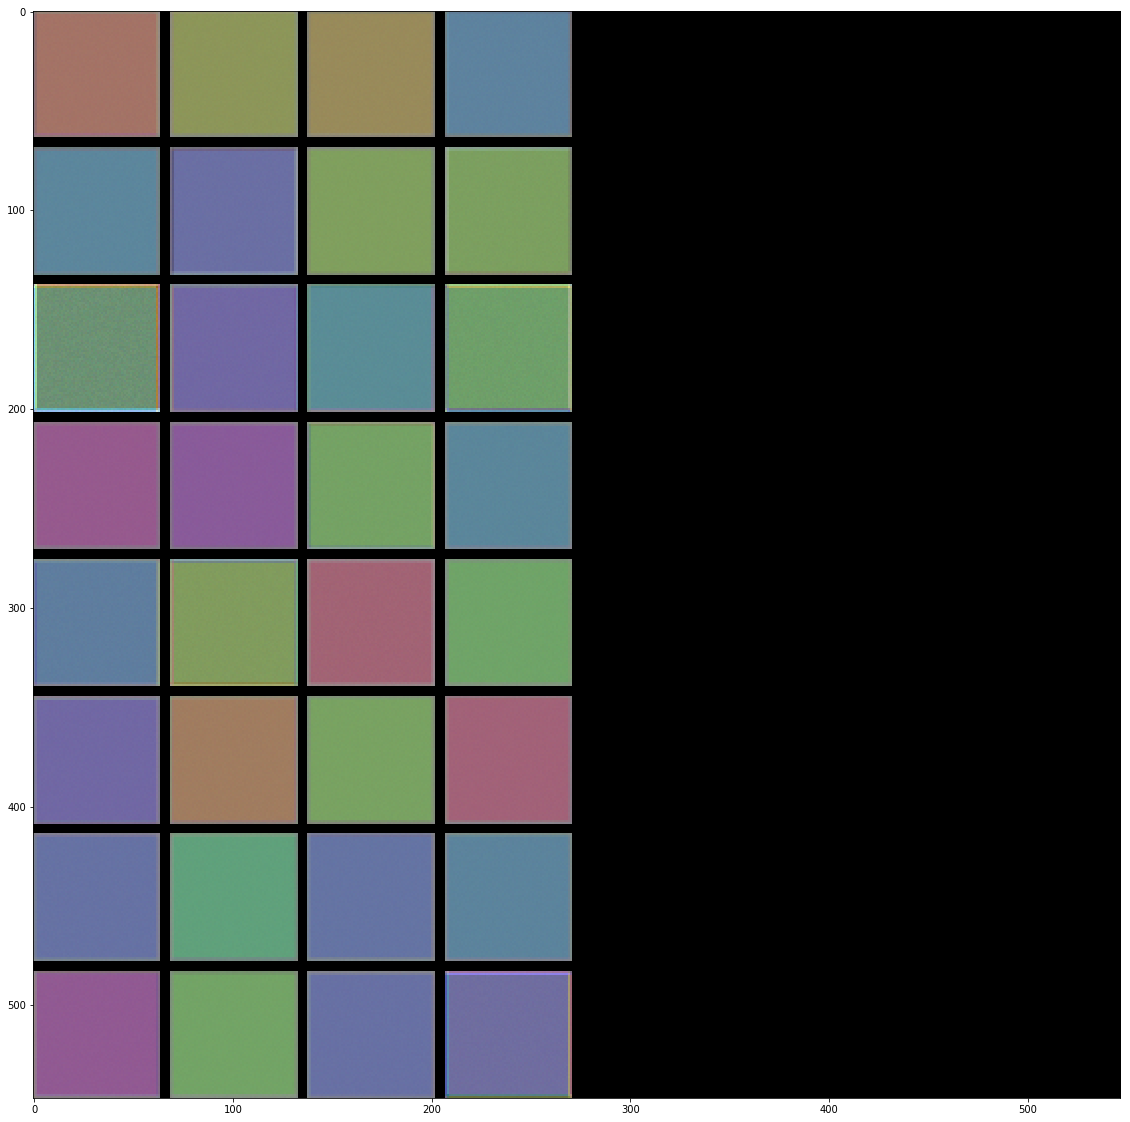

In [14]:
if crop:
    layer_name = 'conv2d_3'
else:
    layer_name = 'conv2d_1'
size = 64
margin = 5
results = np.zeros((8 * size+7*margin, 8 * size+7*margin, 3))
for i in range(8):
    for j in range(4):
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
        horizontal_start=i*size+i*margin
        horizontal_end = horizontal_start + size
        vertical_start=j*size+j*margin
        vertical_end = vertical_start + size
        results[horizontal_start: horizontal_end,vertical_start: vertical_end, :] = filter_img
plt.figure(figsize=(20, 20))
plt.imshow(results.astype(np.uint8))

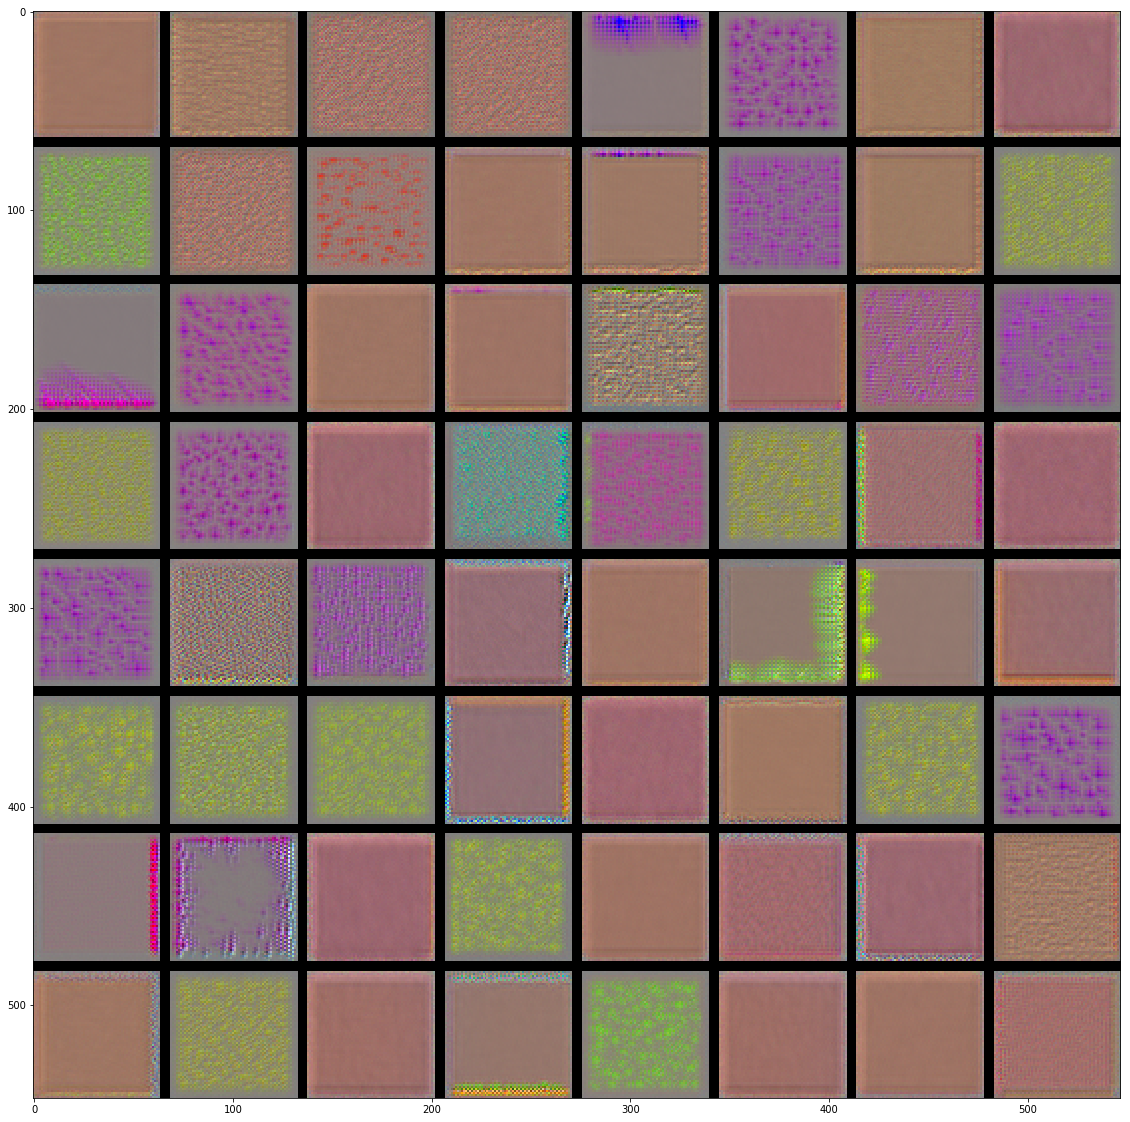

In [15]:
if crop:
    layer_name = 'conv2d_4'
else:
    layer_name = 'conv2d_2'
size = 64
margin = 5
results = np.zeros((8 * size+7*margin, 8 * size+7*margin, 3))
for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
        horizontal_start=i*size+i*margin
        horizontal_end = horizontal_start + size
        vertical_start=j*size+j*margin
        vertical_end = vertical_start + size
        results[horizontal_start: horizontal_end,vertical_start: vertical_end, :] = filter_img
plt.figure(figsize=(20, 20))
plt.imshow(results.astype(np.uint8))

# Intermediate Activations

In [57]:
def combine_labels_images():
    with open('ActivationHeatmap/label_data_copy.json') as json_file:
        data = json.load(json_file)

    orig_str = '/home/emil/Documents/github/BSc-PRO/dataset3/res_still'
    combined = []
    maps = os.listdir(orig_str)
    for m in maps:
        map_str =orig_str+'/'+m
        classes = os.listdir(map_str)
        for k in range(len(classes)):
            path_str = map_str+'/'+classes[k]
            names = os.listdir(path_str)
            count = 0
            for i in range(len(names)):
                for j in range(len(data)):
                    if names[i] == data[j]['External ID'] and (classes[k] != 'background'):
                        combined.append((m ,path_str+'/'+names[i], data[j] ))
    return combined

labels = ['bun','carrots','ketchup','background','catfood_beef','arm','catfood_salmon','potato']
train_path = '../dataset3/res_still/train'
ignore = []
mean_image_train = ii.calulate_mean(train_path, ignore) # Calculates mean for each channel for every pixel
def subtract_mean(img):
    return img - mean_image_train

combined = combine_labels_images()

Predicted: ketchup


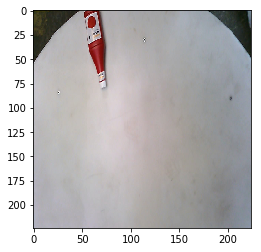

In [129]:
indx = 240
img_path = combined[indx][1]
# load image and resize to 224x224
img = image.load_img(img_path, target_size=(224,224))
plt.imshow(img)
x = image.img_to_array(img) # subtract mean
x = np.expand_dims(x, axis=0)

# Apply preprocessing
x = subtract_mean(x)*1./255
pred = np.argmax(model.predict(x))
print('Predicted: '+str(labels[pred]))

In [59]:
layer_outputs = [layer.output for layer in model.layers[:6]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [130]:
activations = activation_model.predict(x)

layer_activation = activations[3]
print(layer_activation.shape)

<Figure size 432x288 with 0 Axes>

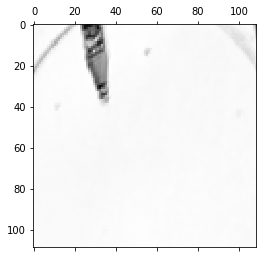

<Figure size 432x288 with 0 Axes>

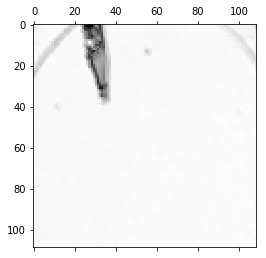

<Figure size 432x288 with 0 Axes>

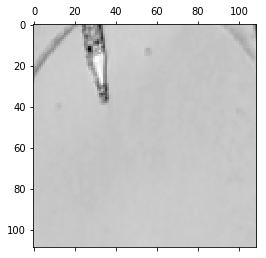

<Figure size 432x288 with 0 Axes>

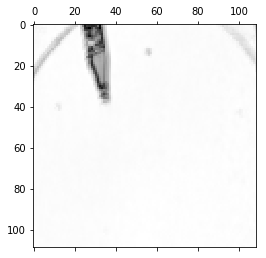

<Figure size 432x288 with 0 Axes>

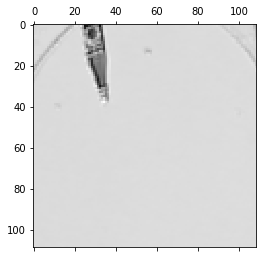

<Figure size 432x288 with 0 Axes>

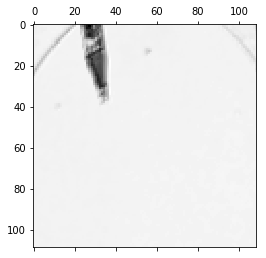

<Figure size 432x288 with 0 Axes>

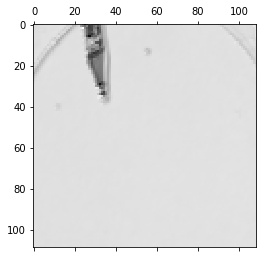

<Figure size 432x288 with 0 Axes>

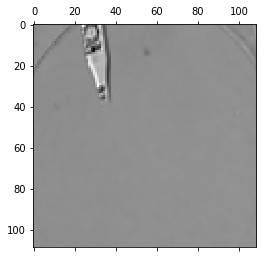

<Figure size 432x288 with 0 Axes>

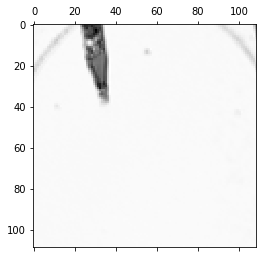

<Figure size 432x288 with 0 Axes>

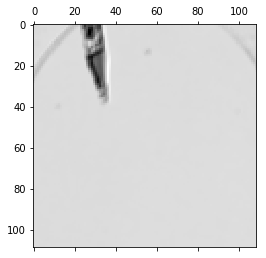

<Figure size 432x288 with 0 Axes>

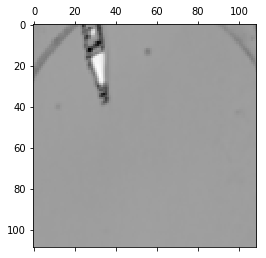

<Figure size 432x288 with 0 Axes>

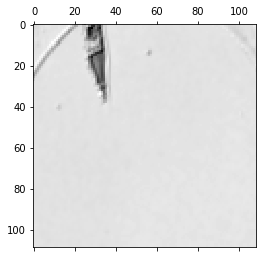

<Figure size 432x288 with 0 Axes>

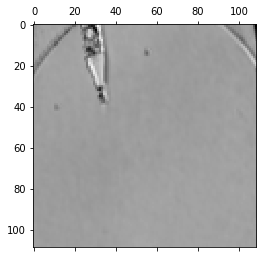

<Figure size 432x288 with 0 Axes>

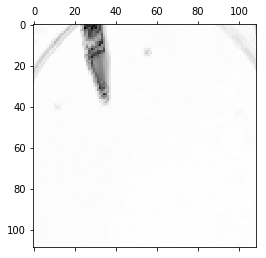

<Figure size 432x288 with 0 Axes>

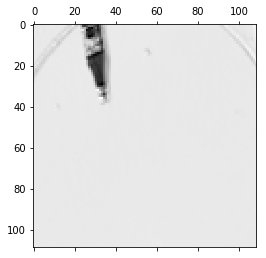

<Figure size 432x288 with 0 Axes>

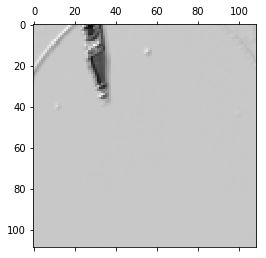

<Figure size 432x288 with 0 Axes>

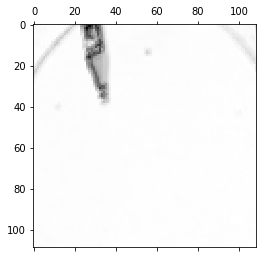

<Figure size 432x288 with 0 Axes>

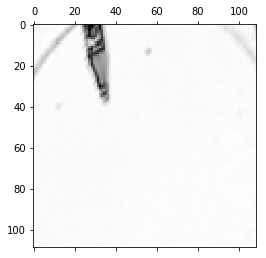

<Figure size 432x288 with 0 Axes>

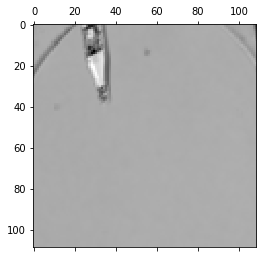

<Figure size 432x288 with 0 Axes>

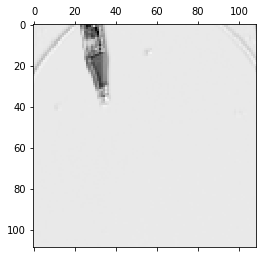

<Figure size 432x288 with 0 Axes>

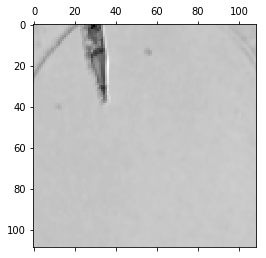

<Figure size 432x288 with 0 Axes>

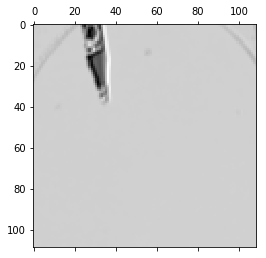

<Figure size 432x288 with 0 Axes>

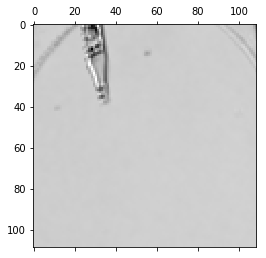

<Figure size 432x288 with 0 Axes>

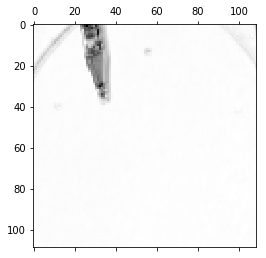

<Figure size 432x288 with 0 Axes>

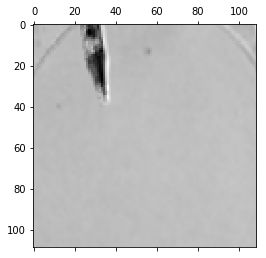

<Figure size 432x288 with 0 Axes>

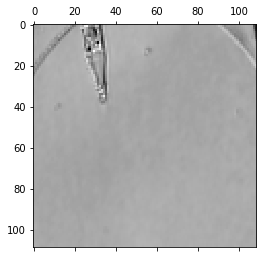

<Figure size 432x288 with 0 Axes>

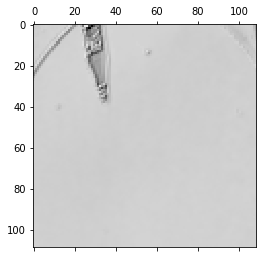

<Figure size 432x288 with 0 Axes>

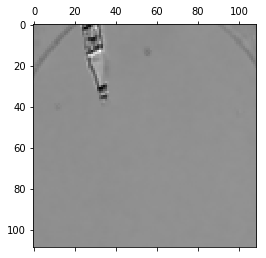

<Figure size 432x288 with 0 Axes>

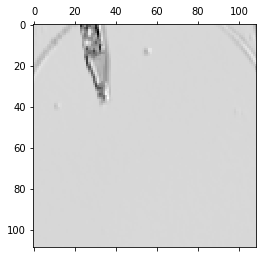

<Figure size 432x288 with 0 Axes>

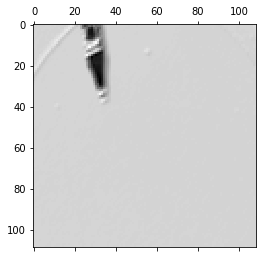

<Figure size 432x288 with 0 Axes>

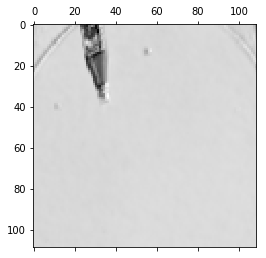

<Figure size 432x288 with 0 Axes>

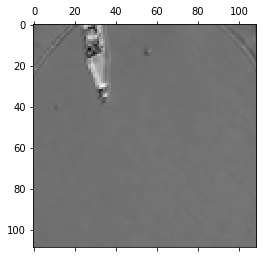

<Figure size 432x288 with 0 Axes>

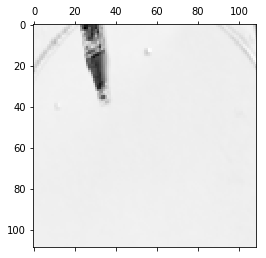

<Figure size 432x288 with 0 Axes>

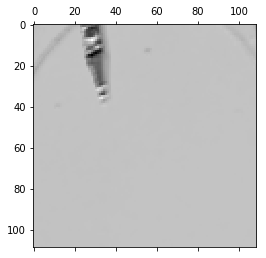

<Figure size 432x288 with 0 Axes>

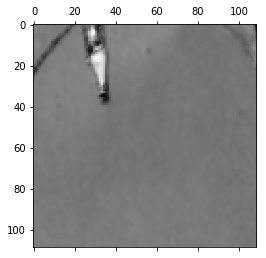

<Figure size 432x288 with 0 Axes>

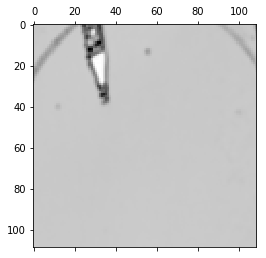

<Figure size 432x288 with 0 Axes>

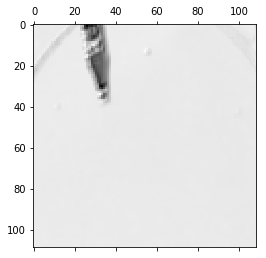

<Figure size 432x288 with 0 Axes>

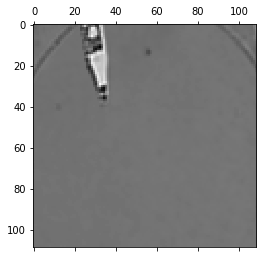

<Figure size 432x288 with 0 Axes>

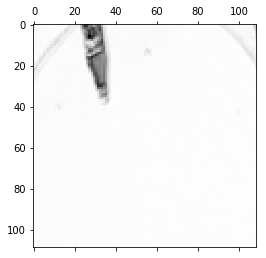

<Figure size 432x288 with 0 Axes>

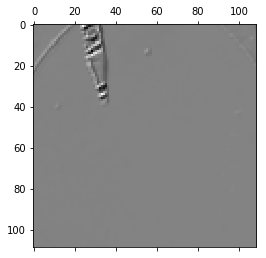

<Figure size 432x288 with 0 Axes>

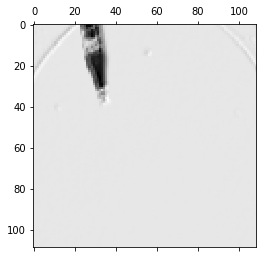

<Figure size 432x288 with 0 Axes>

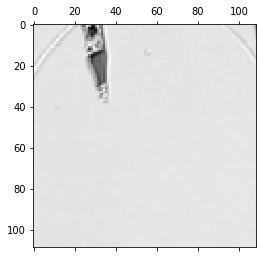

<Figure size 432x288 with 0 Axes>

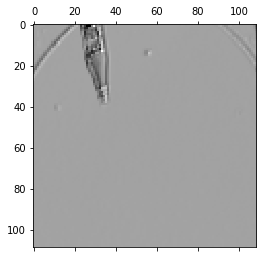

<Figure size 432x288 with 0 Axes>

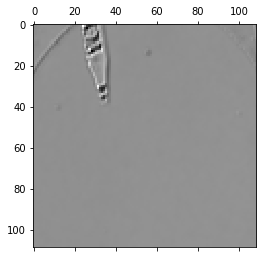

<Figure size 432x288 with 0 Axes>

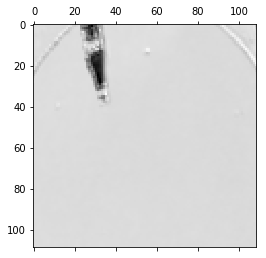

<Figure size 432x288 with 0 Axes>

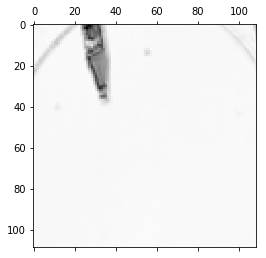

<Figure size 432x288 with 0 Axes>

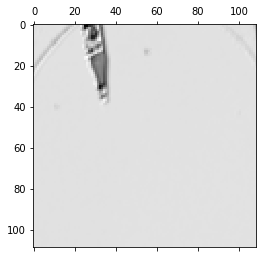

<Figure size 432x288 with 0 Axes>

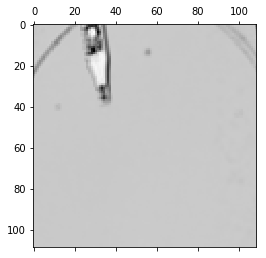

<Figure size 432x288 with 0 Axes>

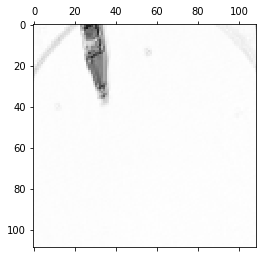

<Figure size 432x288 with 0 Axes>

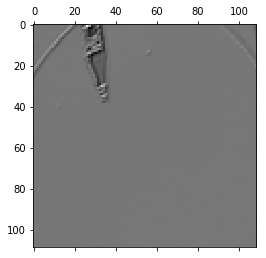

<Figure size 432x288 with 0 Axes>

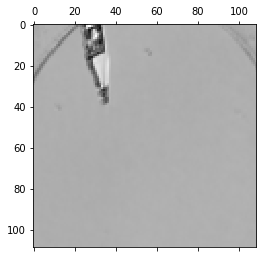

<Figure size 432x288 with 0 Axes>

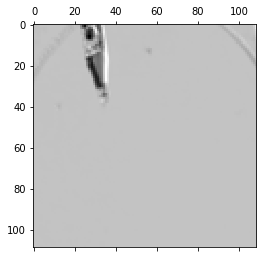

<Figure size 432x288 with 0 Axes>

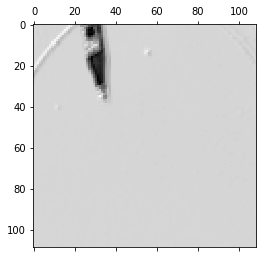

<Figure size 432x288 with 0 Axes>

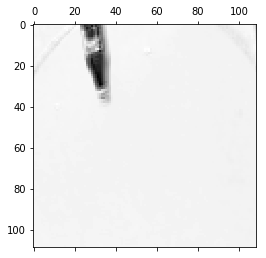

<Figure size 432x288 with 0 Axes>

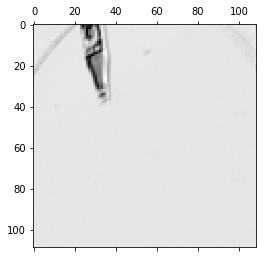

<Figure size 432x288 with 0 Axes>

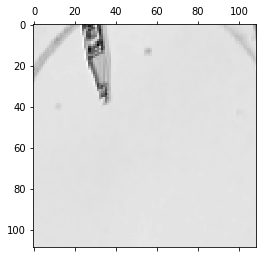

<Figure size 432x288 with 0 Axes>

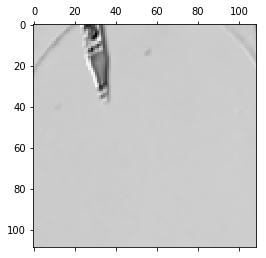

<Figure size 432x288 with 0 Axes>

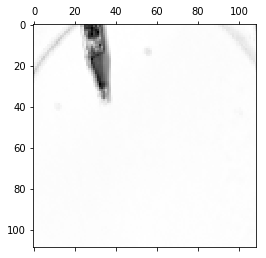

<Figure size 432x288 with 0 Axes>

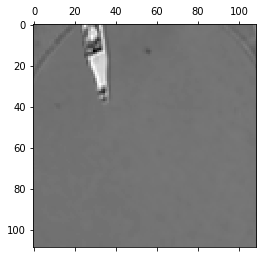

<Figure size 432x288 with 0 Axes>

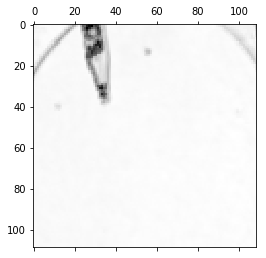

<Figure size 432x288 with 0 Axes>

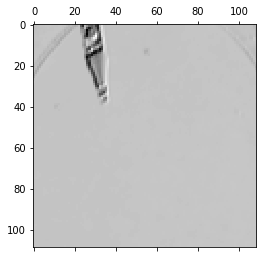

<Figure size 432x288 with 0 Axes>

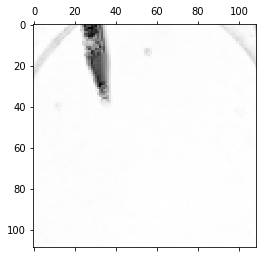

<Figure size 432x288 with 0 Axes>

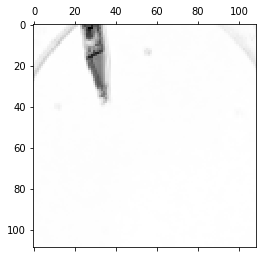

<Figure size 432x288 with 0 Axes>

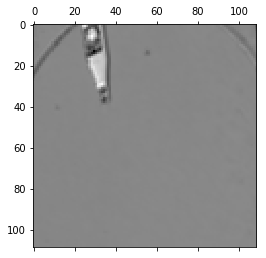

In [133]:
for i in range(64):
    plt.figure()
    plt.matshow(layer_activation[0, :, :, i], cmap='gray')

# Plot filters

In [2]:
crop = True

# Load model
model = cnn_net()
# Uncropped: cnn_weights
# Cropped: cnn_crop_weights
if crop:
    model.load_weights('ActivationHeatmap/cnn_crop_weights.hdf5')
else:
    model.load_weights('ActivationHeatmap/cnn_weights.hdf5')


In [3]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
activation_2 (Activation)    (None, 109, 109, 64)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 186624)            0         
__________

In [14]:
layer_name = 'conv2d_1'
layer = model.get_layer(layer_name)
weights = layer.get_weights()[0]

In [18]:
x_min = tf.reduce_min(weights)
x_max = tf.reduce_max(weights)
weights_0_to_1 = (weights - x_min) / (x_max - x_min)
weights_0_to_255_uint8 = tf.image.convert_image_dtype (weights_0_to_1, dtype=tf.uint8)

weights_transposed = tf.transpose (weights_0_to_255_uint8, [3, 0, 1, 2])

# this will display random 3 filters from the 64 in conv1
tf.summary.image('conv2d_1/filters', weights_transposed)

<tf.Tensor 'conv2d_1/filters:0' shape=() dtype=string>

In [ ]:
# Visualize conv1 features
with tf.variable_scope('conv1') as scope_conv:
    weights = tf.get_variable('weights')

    # scale weights to [0 255] and convert to uint8 (maybe change scaling?)
    x_min = tf.reduce_min(weights)
    x_max = tf.reduce_max(weights)
    weights_0_to_1 = (weights - x_min) / (x_max - x_min)
    weights_0_to_255_uint8 = tf.image.convert_image_dtype (weights_0_to_1, dtype=tf.uint8)

    # to tf.image_summary format [batch_size, height, width, channels]
    weights_transposed = tf.transpose (weights_0_to_255_uint8, [3, 0, 1, 2])

    # this will display random 3 filters from the 64 in conv1
    tf.image_summary('conv1/filters', weights_transposed, max_images=3)

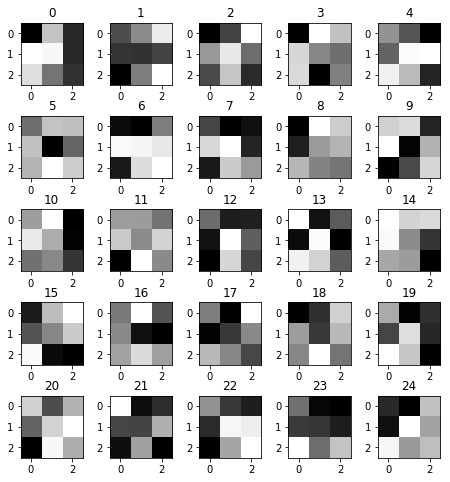

In [40]:
import pylab as pl
import matplotlib.cm as cm
import numpy.ma as ma
def make_mosaic(imgs, nrows, ncols, border=1):
    """
    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols
    """

    nimgs = imgs.shape[0]
    imshape = imgs.shape[1:]
    
    mosaic = ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                            ncols * imshape[1] + (ncols - 1) * border),
                            dtype=np.float32)
    
    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    for i in xrange(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols
        
        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = imgs[i]
    return mosaic
# utility functions
from mpl_toolkits.axes_grid1 import make_axes_locatable

def nice_imshow(ax, data, vmin=None, vmax=None, cmap=None):
    """Wrapper around pl.imshow"""
    if cmap is None:
        cmap = cm.jet
    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im = ax.imshow(data, vmin=vmin, vmax=vmax, interpolation='nearest', cmap=cmap)
    pl.colorbar(im, cax=cax)
#pl.imshow(make_mosaic(np.random.random((9, 10, 10)), 3, 3, border=1))

def plot_conv_weights(model, layer):
    W = model.get_layer(name=layer).get_weights()[0]
    if len(W.shape) == 4:
        W = np.squeeze(W)
        W = W.reshape((W.shape[0], W.shape[1], W.shape[2]*W.shape[3])) 
        fig, axs = plt.subplots(5,5, figsize=(8,8))
        fig.subplots_adjust(hspace = .5, wspace=.001)
        axs = axs.ravel()
        for i in range(25):
            axs[i].imshow(W[:,:,i],cmap='gray')
            axs[i].set_title(str(i))

# usage
plot_conv_weights(model, 'conv2d_2')

In [70]:
W = model.get_layer('conv2d_1').get_weights()[0]
W = np.squeeze(W)
W = W.reshape((W.shape[0], W.shape[1], W.shape[2]*W.shape[3])) 
print(W[:,:,0])
cur = W[:,:,0]

[[-0.11651112  0.05979432  0.09901813]
 [ 0.1334965  -0.06533177  0.14151002]
 [ 0.03934923  0.11999758  0.00254313]]


In [71]:
for i in range(cur.shape[0]):
    for j in range(cur.shape[1]):
        cur[i,j] = float((cur[i,j] + 0.11651113) / (0.14151002 + 0.11651113))
print(cur)

[[3.3360639e-08 6.8329841e-01 8.3531624e-01]
 [9.6894234e-01 1.9835335e-01 1.0000000e+00]
 [6.0406041e-01 9.1662526e-01 4.6141279e-01]]


In [72]:
cur*=255.

In [73]:
print(cur)

[[8.5069632e-06 1.7424109e+02 2.1300565e+02]
 [2.4708029e+02 5.0580105e+01 2.5500000e+02]
 [1.5403540e+02 2.3373944e+02 1.1766026e+02]]


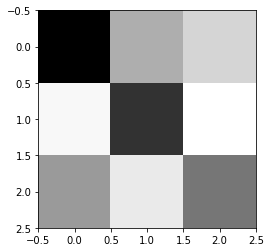

In [75]:
plt.imshow(cur,cmap='gray')